In [1]:
import numpy as np
import gdal
import ogr
from skimage import exposure
from skimage.segmentation import quickshift
import geopandas as gpd
import numpy as np

In [2]:
naip_fn = 'Sentinel_Ploytunnal_APR_2020.tif'

In [3]:
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
nbands = naip_ds.RasterCount
band_data = []

In [4]:
for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()
    band_data.append(band)
band_data = np.dstack(band_data)
img = exposure.rescale_intensity(band_data)

In [7]:
# do segmentation, different options with quickshift and slic (only use one of the next two lines)
import time
segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
#segments = slic(img, n_segments=500000, compactness=0.1)
print('segments complete', time.time() - segments)

segments complete [[1.59851600e+09 1.59851600e+09 1.59851600e+09 ... 1.59851605e+09
  1.59851605e+09 1.59851605e+09]
 [1.59851600e+09 1.59851600e+09 1.59851600e+09 ... 1.59851605e+09
  1.59851605e+09 1.59851605e+09]
 [1.59851600e+09 1.59851600e+09 1.59851600e+09 ... 1.59851605e+09
  1.59851605e+09 1.59851605e+09]
 ...
 [1.59848898e+09 1.59848898e+09 1.59848898e+09 ... 1.59848860e+09
  1.59848860e+09 1.59848860e+09]
 [1.59848898e+09 1.59848898e+09 1.59848898e+09 ... 1.59848860e+09
  1.59848860e+09 1.59848860e+09]
 [1.59848898e+09 1.59848898e+09 1.59848898e+09 ... 1.59848860e+09
  1.59848860e+09 1.59848860e+09]]


In [8]:
# save segments to raster
segments_fn = 'segments.tif'
segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize,
                                1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

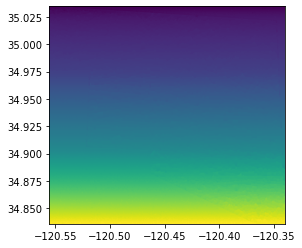

<AxesSubplot:>

In [9]:
import rasterio
from rasterio.plot import show
src = rasterio.open("segments.tif")

show(src)

In [10]:
def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

In [12]:
import scipy
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

c:\python37\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\python37\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
# read shapefile to geopandas geodataframe
gdf = gpd.read_file('Polytunnels_Black.shp')
# get names of land cover classes/labels
class_names = gdf['label'].unique()
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
# create a pandas data frame of the labels and ids and save to csv
df = pd.DataFrame({'label': class_names, 'id': class_ids})
df.to_csv('C:/temp/naip/class_lookup.csv')
# add a new column to geodatafame with the id for each class/label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

ValueError: GEOSGeom_createLinearRing_r returned a NULL pointer